<a href="https://colab.research.google.com/github/ferjozsot23/machine-learning/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fernando José Soto Jácome

# Objetivos
1. Predecir la clase de un dataset que contenga dos categorías mediante Logistic Regression
1. Revisar los métodos de preprocesamiento de datos
1. Analizar las predicciones obtenidas mediante Logistic Regression

# Introducción
Una vez realizado una efectiva selección e ingeniería de características, es importante encontrar las relaciones que existe entre cada una de ellas. Especialmente, explicar cómo las variables independientes tienen una correspondencia con las variables dependientes. Tomar en cuenta la dinámica entre variables, permitirá una correcta predicción a partir de un dataset.

La técnica de Logistic Regression permite relacionar las variables y predecir a qué clase pertenecerá un nuevo registro. Esto se realiza a través estimando las probabilidades utilizando una función logística. Esta función es sigmoidea, y es usada en modelos de regresión logística por estar limitada entre 0 y 1, su derivada es fácil de computar, introduce a modelos no lineares.

En este informe se utilizará un dataset para indicar si un cliente compró o no un automóvil, mediante variables predictoras involucradas dentro del dataset car_data.csv

# Ejercicios presentados

In [ ]:
!pip install mord

Processing c:\users\usuario\appdata\local\pip\cache\wheels\1d\94\48\b3d11f5f91d26bec0c95c6eb9c27c6e427d0b77fb2406d0e0a\mord-0.6-py3-none-any.whl


In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from graphs import gainsChart, liftChart
from metric import AIC_score, classificationSummary

## dataset de decisión de compra, que indica si un cliente compró o no un automóvil obtenido de https://www.kaggle.com/

In [ ]:
car_df = pd.read_csv("car_data.csv")
car_df.head()

### Future Selection: "User ID" and "Gender" no son variables relevantes

In [ ]:
car_df.drop(columns=['User ID','Gender'], inplace=True)

In [ ]:
print(car_df.columns)

Index(['Gender', 'Age', 'AnnualSalary', 'Purchased'], dtype='object')


### Transformación de variables predictoras a dommies

In [ ]:
car_df = pd.get_dummies(car_df, prefix_sep='_', drop_first=True)
car_df.head()

,Age,AnnualSalary,Purchased,Gender_Male
0,35,20000,0,1
1,40,43500,0,1
2,49,74000,0,1
3,40,107500,1,1
4,25,79000,0,1


In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Age           1000 non-null   int64
 1   AnnualSalary  1000 non-null   int64
 2   Purchased     1000 non-null   int64
 3   Gender_Male   1000 non-null   uint8
dtypes: int64(3), uint8(1)
memory usage: 24.5 KB


In [ ]:
y = car_df['Purchased']
X = car_df.drop(columns=['Purchased'])

In [ ]:
car_df.shape

(1000, 4)

### Entrenar el modelo

In [ ]:
# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

LogisticRegression(C=1e+42, solver='liblinear')

In [ ]:
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -11.192255898149043
            Age  AnnualSalary  Gender_Male
coeff  0.209768      0.000026     0.373296

AIC 418.31991567880004


### Desplegar las probabilidades de los registros de haber o no comprado el carro con respecto al valor real

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result.head())
print()


     actual      p(0)      p(1)  predicted
507       0  0.944013  0.055987          0
818       1  0.756529  0.243471          0
452       0  0.441301  0.558699          1
368       0  0.611163  0.388837          0
242       1  0.698184  0.301816          0



In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
print()
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8400)

       Prediction
Actual   0   1
     0 314  37
     1  59 190

Confusion Matrix (Accuracy 0.8375)

       Prediction
Actual   0   1
     0 222  25
     1  40 113


### Evaluar el nivel de precisión del modelo

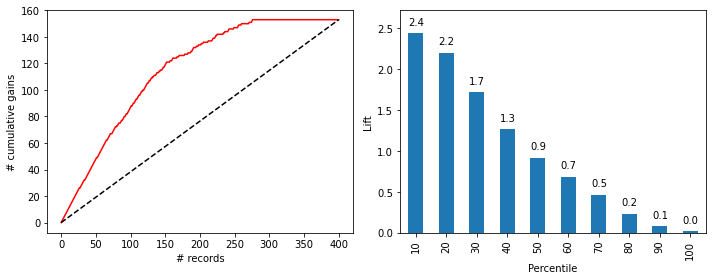

In [ ]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0], color='r')
liftChart(df['p(1)'], title=False, ax=axes[1])

plt.tight_layout()
plt.show()

#### Mientras más grande sea el área entre la curva y modelo de referencia, el modelo será más preciso

## Entrenar el modelo sólo con una variable predictora

### 1. Se evalúa con Gender

In [ ]:
predictors = ['Gender_Male']
outcome = 'Purchased'

y = car_df[outcome]
X = car_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -0.3191370216760204
             Gender_Male
coefficient    -0.051237

AIC 756.7401762775194


In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result.head())
print()

     actual      p(0)      p(1)  predicted
507       0  0.579114  0.420886          0
818       1  0.579114  0.420886          0
452       0  0.591549  0.408451          0
368       0  0.579114  0.420886          0
242       1  0.591549  0.408451          0



In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
print()
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.5850)

       Prediction
Actual   0   1
     0 351   0
     1 249   0

Confusion Matrix (Accuracy 0.6175)

       Prediction
Actual   0   1
     0 247   0
     1 153   0


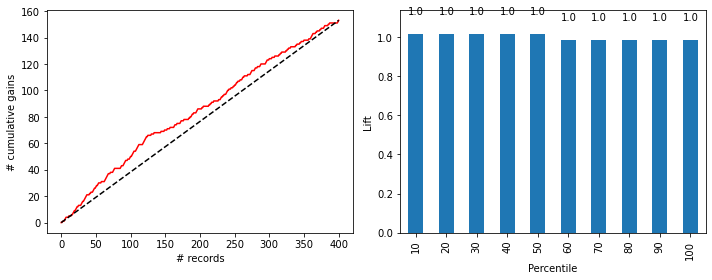

In [ ]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0], color='r')
liftChart(df['p(1)'], title=False, ax=axes[1])

plt.tight_layout()
plt.show()

### Como se logra apreciar, predecir si el cliente compra o no el vehículo es poco preciso si solamente se toma en cuenta la variable "Género"

### 2. Se evalúa con "AnnualSalary"

In [ ]:
predictors = ['AnnualSalary']
outcome = 'Purchased'

y = car_df[outcome]
X = car_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -1.7622201903499684
             AnnualSalary
coefficient      0.000019

AIC 497.37566159009793


In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

print(logit_result.head())
print()

     actual      p(0)      p(1)  predicted
507       0  0.561659  0.438341          0
818       1  0.559298  0.440702          0
452       0  0.568725  0.431275          0
368       0  0.587423  0.412577          0
242       1  0.497280  0.502720          1



In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
print()
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.7483)

       Prediction
Actual   0   1
     0 328  23
     1 128 121

Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual   0   1
     0 240   7
     1  73  80


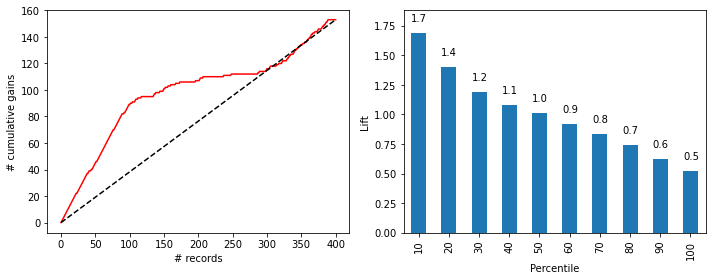

In [ ]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0], color='r')
liftChart(df['p(1)'], title=False, ax=axes[1])

plt.tight_layout()
plt.show()

### El modelo responde mejor cuando la variable dependiente está relacionada con el dinero, en este caso "AnnualSalary", por tanto, es más relevante que "Género"

# Conclusiones

1. Se concluye que  el algoritmo de aprendizaje supervisado Logistic Regression permite predecir la pertenencia de una variable a una clase determinada.

1. Se concluye realizar la matriz de confusión es importante para determinar y analizar la precisión del modelo a partir de los datos de entrenamiento. Esta matriz permite comparar los datos de predicción y reales, en escenarios con datos vistos y con no vistos.

1. Se concluye que a medida que se utilice una mayor cantidad de variables predictoras, siempre y cuando hayan pasado por el proceso de selección e ingeniería de características, el modelo arrojará mejores niveles de precisión debido a que fue entrenado variables relevantes

# Bibliografía

Susan Li. (Septiembre de 2017). Building A Logistic Regression in Python, Step by Step  Obtenido de https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
